## 3. Convolutional Nueral Network

 ### 1) import modules

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

 ### 2) define placeholder for INPUT & LABELS

In [2]:
INPUT = tf.placeholder(tf.float32, [None, 784])
LABELS = tf.placeholder(tf.int32, [None])

### 3) define cnn model

<img src="./images/cnn.png" alt="slp model" width="1000" align="left"/>

###  understanding convolution ##

<img src="./images/conv2d.png" alt="conv2d" width="800" align="left"/>
<img src="./images/conv2d_2.png" alt="conv2d" width="800" align="left"/>

####  - define convolutional_neural_network function with tf.nn.conv2d, tf.nn.max_pool, tf.nn.tanh

In [3]:
def convolutional_neural_network(input, output_dim=None):
    image = tf.reshape(input, [-1, 28, 28, 1]) #batch_size x height x width x channel

    # Conv layer1
    # Filter가 Weight 역활을 함
    W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 20], stddev=0.1))
    b_conv1 = tf.Variable(tf.zeros([20]))
    h_conv1 = tf.nn.conv2d(
            image, 
            W_conv1, 
            strides=[1, 1, 1, 1], 
            padding='SAME') + b_conv1 # batch_sizex28x28x20
    fmap_conv1 = tf.nn.tanh(h_conv1)

    # Pooling(Max) layer1
    # k_size = [one_image, height, width, one_channel]
    h_pool1 = tf.nn.max_pool(
        fmap_conv1, 
        ksize=[1, 2, 2, 1], 
        strides=[1, 2, 2, 1], 
        padding='SAME'
    ) # batch_sizex14x14x20

    # Conv layer2
    # Filter가 Weight 역활을 함
    W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 20, 50], stddev=0.1))
    b_conv2 = tf.Variable(tf.zeros([50]))
    h_conv2 = tf.nn.conv2d(
        h_pool1, 
        W_conv2, 
        strides=[1, 1, 1, 1], 
        padding='SAME') + b_conv2 # batch_sizex14x14x50
    fmap_conv2 = tf.nn.tanh(h_conv2)

    # Pooling(Max) layer2
    h_pool2 = tf.nn.max_pool(
        fmap_conv2, 
        ksize=[1, 2, 2, 1], 
        strides=[1, 2, 2, 1], 
        padding='SAME'
    ) # batch_sizex7x7x50
    h_pool2_flat = tf.reshape(h_pool2, [-1, 2450])  # batch_sizex(2450=7*7*50)
    
    # fully-connected layer1
    W_fc1 = tf.Variable(tf.truncated_normal([2450, 500], stddev=0.1))
    b_fc1 = tf.Variable(tf.zeros([500]))
    h_fc1 = tf.nn.tanh(tf.matmul(h_pool2_flat, W_fc1) + b_fc1) # batch_sizex500

    # fully-connected layer2
    W_fc2 = tf.Variable(tf.truncated_normal([500, output_dim], stddev=0.1))
    b_fc2 = tf.Variable(tf.zeros([output_dim]))
    output = tf.matmul(h_fc1, W_fc2) + b_fc2 #batch_sizex10

    return output

### 4) define computational graph

In [4]:
logits = convolutional_neural_network(INPUT, output_dim=10)
prediction = tf.nn.softmax(logits)
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=LABELS, logits=logits
)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

### 5) load data

In [5]:
mnist = input_data.read_data_sets("./data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### 6) start training
   #### - set training parameters : batch size, total loop

In [6]:
BATCH_SIZE = 100
TOTAL_LOOP = 10000

 - arrA = [[0,0,0,0,1],[0,1,0,0,0]]
 - np.where(arrA) => ([0,1], [4,1])
 - ref) https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.where.html?highlight=numpy%20where#numpy.where

In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for loop in range(1, TOTAL_LOOP + 1):
    
    train_images, train_labels = mnist.train \
                                      .next_batch(BATCH_SIZE)
    train_labels = np.where(train_labels)[1]
        
    _, loss = sess.run(
        [optimizer, cost],
        feed_dict={
            INPUT: train_images, 
            LABELS: train_labels
        }
    )
    
    if loop % 500 == 0 or loop == 0:
        print("loop: %05d,"%(loop), "loss:", loss)

print("Training Finished! (loss : " + str(loss) + ")")

loop: 00500, loss: 0.2690411
loop: 01000, loss: 0.24095076
loop: 01500, loss: 0.23393078
loop: 02000, loss: 0.1767907
loop: 02500, loss: 0.14063485
loop: 03000, loss: 0.14819191
loop: 03500, loss: 0.083298095
loop: 04000, loss: 0.09189237
loop: 04500, loss: 0.11554107
loop: 05000, loss: 0.15248106
loop: 05500, loss: 0.06879229
loop: 06000, loss: 0.08341271
loop: 06500, loss: 0.12126176
loop: 07000, loss: 0.052808806
loop: 07500, loss: 0.038673032
loop: 08000, loss: 0.049559455
loop: 08500, loss: 0.06827713
loop: 09000, loss: 0.028423809
loop: 09500, loss: 0.04403933
loop: 10000, loss: 0.050582036
Training Finished! (loss : 0.050582036)


### 7) test performance

 - test image shape: (10000, 784)
 - test label shape: (10000, 10) 
 

 - arrB = [[0, 1, 2],[3, 4, 5]]
 - np.argmax(arrB) => 5
 - np.argmax(arrB, axis=0) => [1, 1, 1]
 - np.argmax(arrB, axis=1) => [2, 2]
 - ref) https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.argmax.html
 

In [9]:
pred_result = sess.run(
    prediction, 
    feed_dict={INPUT: mnist.test.images}
)
pred_number = np.argmax(pred_result, axis=1)
label_number = np.where(mnist.test.labels)[1]

print("Test Accuracy:", 100*np.mean(pred_number == label_number))


Test Accuracy: 98.34


### 8) error

(166, 28, 28)


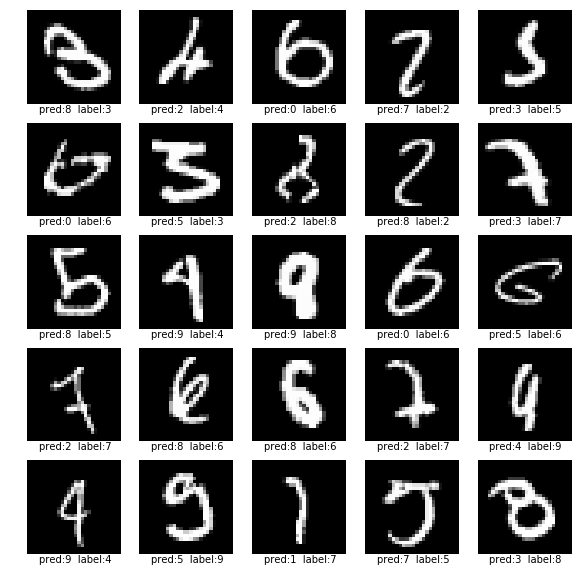

In [12]:
fault_idx = pred_number != label_number
fault_image = mnist.test.images[fault_idx].reshape([-1,28,28])
fault_pred = pred_number[fault_idx]
fault_label = label_number[fault_idx]

print(fault_image.shape)

from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(5, 5)
gs.update(wspace=0.05)

for i in range(25):
    plt.subplot(gs[i])
    plt.axis('off')
    plt.imshow(fault_image[i], cmap = 'gray')
    plt.text(3,30,"pred:{}  label:{}".format(fault_pred[i], fault_label[i]))
    
sess.close()